In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#imports for k-means
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.metrics import *
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy import stats
from scipy.stats import mode
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage, dendrogram

from itertools import combinations

from scipy.cluster.hierarchy import fcluster

import matplotlib.cm as cm
import pickle

import ipympl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from collections import Counter
import math
import os

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, fclusterdata

In [45]:
def barChart(df, title_, xlabel_, ylabel_, legend, legend_title, xticks_, save, rotation_,yscale=False,yaxis=[]):
    ax=df.plot(kind='bar', figsize=(10,6), width=0.9, fontsize=14)
    ax.set_title(title_, {'fontsize':20})
    ax.set_xlabel(xlabel_, { 'size'   : 17})
    ax.set_ylabel(ylabel_,  {'size'   : 17})
    if(len(xticks_)>0):
        x_pos = [i for i, _ in enumerate(xticks_)]
        plt.xticks(x_pos, xticks_, rotation=rotation_)
    if(yscale):
        plt.yscale('log')
    if(len(yaxis)>0):
        ax.yaxis.set_ticks(yaxis)
    if legend:
        leg=ax.legend(fontsize=12, loc='center left', bbox_to_anchor=(1, 0.7))
        leg.set_title(title=legend_title,  prop = {'size':'x-large'})
    else:
        leg=ax.legend()
        leg.set_visible(False)
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    if save : 
        plt.savefig(title_+'.pdf', dpi=1000, bbox_inches = "tight", pad_inches = 1)
    plt.show()
    

def plot_res(data, test_dict, link, n_clu, ps_type):
    d = test_dict[link]['sh']
    data_fc = data.copy()
    fc_ = test_dict[link]['fc'][n_clu]
    data_fc['fc'] = fc_
    
    print('sh = ' + str(d[n_clu]) + ' - num_cl = ' + str(n_clu))
    print('  -> ' + str(dict(Counter(data_fc['fc']))))
    
    if ps_type == 'mode':
        result=pd.DataFrame(data_fc.groupby(['fc'], as_index=False).agg({'ps_mode': lambda x:stats.mode(x)[0]}))
        result.drop('fc',axis=1,inplace=True)
        barChart(result,'Payment Satuts','Clusters','Values', True,'',result.index,0,90,False)
    elif ps_type == 'mean':
        result=pd.DataFrame(data_fc.groupby(['fc'], as_index=False).agg({'ps_m': np.mean}))
        result.drop('fc',axis=1,inplace=True)
        barChart(result,'Payment Satuts','Clusters','Values', True,'',result.index,0,90,False)

    result=pd.DataFrame(data_fc.groupby(['fc'], as_index=False).agg({'limit':np.mean,'ba_m':np.mean,'pa_m':np.mean}))
    result.drop('fc',axis=1,inplace=True)
    barChart(result,"title","Clusters","Values",True,"",result.index,0,90,False)

    crosstab = pd.crosstab(data_fc['fc'], data_fc['credit_default'],normalize='index')
    crosstab.plot(kind='bar', stacked=True, title='Default by ' + str('credit_default') + ' class')
    
    result=pd.DataFrame(data_fc.groupby(['fc'], as_index=False).agg({'age':np.mean}))
    result.drop('fc',axis=1,inplace=True)
    barChart(result,"Age","Clusters","Values",True,"",result.index,0,90,False)

    cross=pd.crosstab(data_fc['fc'],data_fc['education'])
    barChart(cross,'Education','Cluster','Values',True,"",cross.index,0,90,False)

    cross=pd.crosstab(data_fc['fc'],data_fc['sex'])
    barChart(cross,'sex','Cluster','Values',True,"",cross.index,0,90,False)

    cross=pd.crosstab(data_fc['fc'],data_fc['status'])
    barChart(cross,'Status','Cluster','Values',True,"",cross.index,0,90,False)
    
    
def plot_scatt (data, test_dict, link, n_clu, att_pairs):
    for n_c in n_clu:
        print(link)
        d = test_dict[link]['sh']
        data_fc = data.copy()
        fc_ = test_dict[link]['fc'][n_c]
        data_fc['fc'] = fc_
        print('sh = ' + str(d[n_c]) + ' - num_cl = ' + str(n_c))
        print('  -> ' + str(dict(Counter(data_fc['fc']))))

        for x,y in att_pairs:
            fig = plt.figure()
            plt.scatter(data[x], data[y], c=fc_, s=20)
            plt.xlabel(x)
            plt.ylabel(y)
            plt.show()
            #plt.savefig('scatt_age_ps_'+ str(n_c) + 'clu')
            plt.clf()


def plot_sh (test_dict):
    d_ = {l: [test_dict[l]['sh'][k] for k in test_dict[l]['sh']] for l in linkage_list}
    df_ = pd.DataFrame(data=d_)

    fig = plt.figure()

    plt.plot(df_['ward'], 'c')
    plt.plot(df_['complete'], '--c')
    plt.plot(df_['average'], ':c')

    plt.ylim(top=1)
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, 30, step=2), [x for x in range(2,31,2)])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette coefficient')

    plt.show()
    #plt.savefig('hier_num_clust_sh.png')
    #plt.clf()
    

def plot_dend (test_dict, lin, n_clu):
    for n_ in n_clu:
        data_l = test_dict[lin]['data_link']
        fig = plt.figure()
        res = dendrogram(data_l, truncate_mode='lastp', no_labels=True, show_leaf_counts=True)

        n_c = len(set(res['color_list']))
        max_h = max(max(res['icoord']))/20
        if n_c < n_ + 1:
            n_c = n_c + n_ + 1

        while n_c > n_ + 1:
            plt.clf()
            res = dendrogram(data_l, color_threshold=max_h, truncate_mode='lastp', no_labels=True, show_leaf_counts=True)
            max_h = max_h - 0.2
            n_c = len(set(res['color_list']))
            if n_c < n_ + 1:
                n_c = n_c + n_ + 1

In [4]:
def hier_clu_n(df, max_clu, dist_):
    data_link_dict = dict() #[lin-euclidean, data_link]
    res_dict = dict() #[lin-euclidean, dendogram]
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(df.values)
    data_dist = pdist(X, metric=dist_)

    #os.makedirs('.\\' + name) #directiory folder test name 

    linkage_list = ['ward', 'complete', 'average'] #'single'

    for lin in linkage_list:
        #path = '.\\' + name + '\\'
        
        data_link = linkage(data_dist, method=lin, metric=dist_)
        res = dendrogram(data_link, truncate_mode='lastp')
        '''
        #save the dednogram as image
        plt.gcf()
        plt.savefig(path + name + '_' + lin)
        plt.clf()
        '''

        #dictionary update
        data_link_dict.update([(lin, data_link)])
        res_dict.update([(lin, res)])

    sh_scores = dict()
    fc_dict = dict()
    df_fc_dict = dict()
    l = list()                

    for k in linkage_list:
        #path = '.\\' + name + '\\'
        d = dict()
        f = dict()
        e = dict()
        res_k = res_dict[k]
        data_link_k = data_link_dict[k]
        
        for n in range(2, max_clu):
            fc = fcluster(data_link_k, n, criterion='maxclust')
            sh = silhouette_score(X, fc)
            
            d.update([(n,sh)])
            sh_scores.update([(k, d)])
            f.update([(n,fc)])
            fc_dict.update([(k, f)])
            

            #scatter_martix
            df_fc = df.copy()
            df_fc['fc'] = fc
            '''
            ord_list = [k for k in Counter(cc_fc['fc'])]
            sns.set(style="ticks")
            sns.pairplot(cc_fc, hue='fc', hue_order= ord_list[::-1], plot_kws = {'alpha': 0.8, 's': 80})
            plt.gcf()
            plt.savefig(path + name + '_' + k + '_SM')
            plt.clf()
            '''
            e.update([(n, df_fc)])
            df_fc_dict.update([(k, e)])
            
        l.append({
            'data_link':data_link_dict[k],
            'res':res_dict[k],
            'fc':fc_dict[k],
            'sh':sh_scores[k],
            'df_fc':df_fc_dict[k]
        })

    return dict([('ward', l[0]), ('complete', l[1]), ('average', l[2])])


def hier_clu(test_name, df, max_clu, dist_):
    r_ = hier_clu_n(df, max_clu, dist_)
    
    f = open(test_name + ".pkl","wb")
    pickle.dump(r_,f)
    f.close()

In [5]:
cc_ = pd.read_csv('C:\\Users\\Richard\\Desktop\\DM_proj\\credit_default_FINAL.csv')
cc_2 = pd.read_csv('C:\\Users\\Richard\\Desktop\\DM_proj\\data2.csv')
cc_2 = cc_2.drop(columns=['Lab'])

linkage_list = ['ward', 'complete', 'average']

In [62]:
cc_2.head()

,limit,sex,education,status,age,ps-sep,ps-aug,ps-jul,ps-jun,ps-may,...,pa-aug,pa-jul,pa-jun,pa-may,pa-apr,credit_default,ps_mode,ba_m,pa_m,ps_m
0,50000,male,graduate school,single,25,2,0,0,0,0,...,1905,1811,1100,1100,1200,no,0.0,43317.666667,1541.000000,0.333333
1,200000,male,university,married,54,0,0,0,0,0,...,7852,6336,4622,7956,5499,no,0.0,7914.333333,7064.166667,0.000000
2,30000,female,high school,married,39,2,3,2,2,2,...,1700,1100,3,1053,1303,no,2.0,29802.833333,859.833333,1.833333
3,140000,female,university,single,31,0,0,0,0,0,...,2000,900,2000,10000,5000,no,0.0,36138.000000,3650.000000,0.000000
4,60000,female,high school,married,36,1,2,2,0,0,...,0,1894,1801,3997,0,yes,0.0,49241.166667,1580.000000,0.833333


In [8]:
#read file pickle
for i in range(1,4):
    name_ = 'test_' + str(i) + '_30'
    with open('.\\' + name_ + '.pkl', 'rb') as f:
        vars()[name_] = pickle.load(f)

# Test 1 - limit, all pa, all ba

In [50]:
cc = cc_2[['limit', 'ba-apr', 'ba-may', 'ba-jun', 'ba-jul', 'ba-aug', 'ba-sep', 'pa-apr', 'pa-may', 'pa-jun', 'pa-jul', 'pa-aug', 'pa-sep' ]] #test_1

In [32]:
#test_1_30 = hier_clu_n(cc, 31, 'euclidean') #dictionary of test 1 - 30 cluster

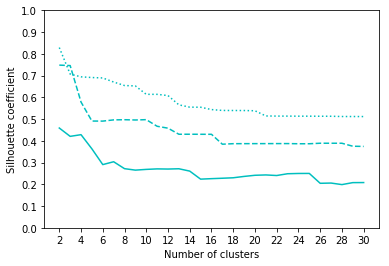

In [34]:
plot_sh(test_1_30)

sh = 0.4283042637747065 - num_cl = 4
  -> {4: 6298, 2: 1997, 3: 1510, 1: 165}


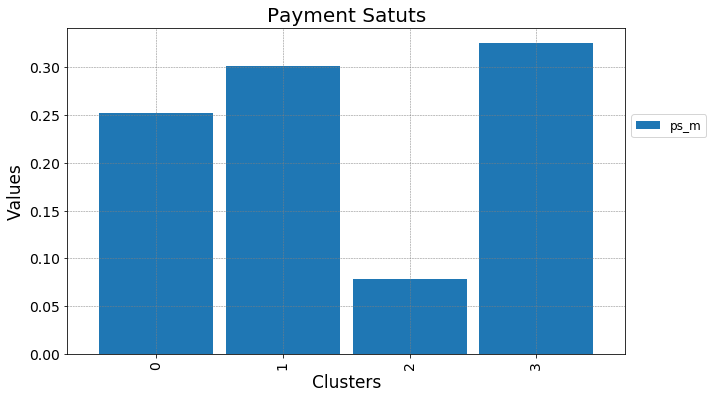

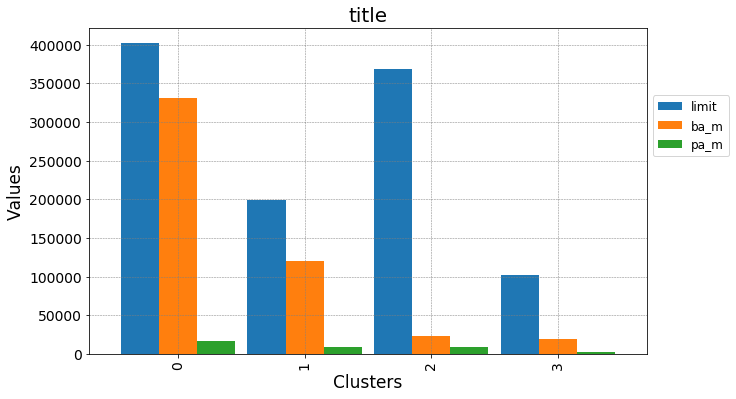

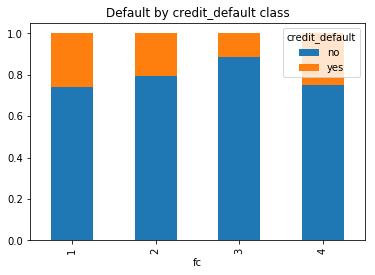

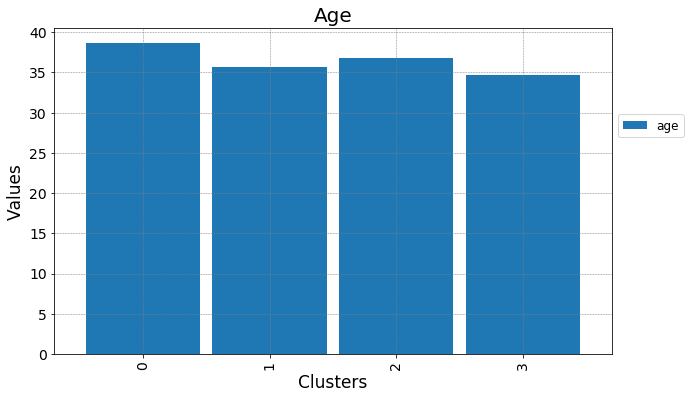

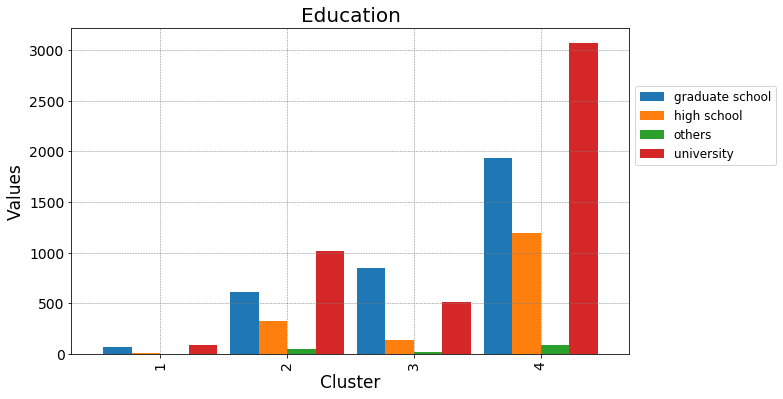

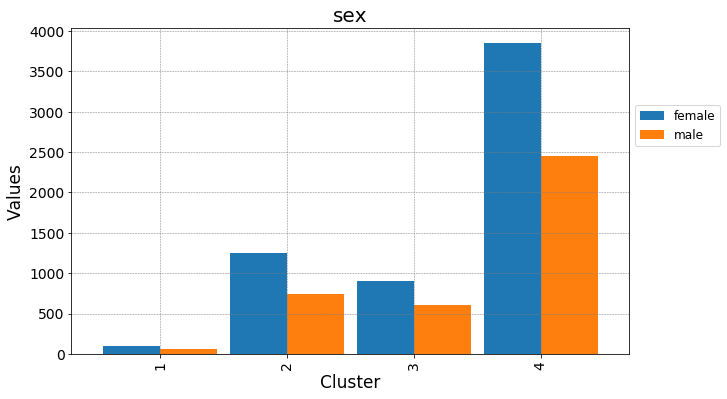

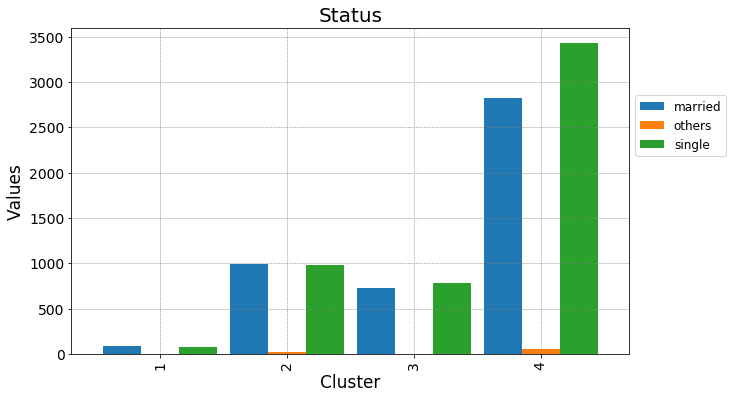

In [77]:
plot_res(cc_2, test_1_30, 'ward', 4, 'mean') # 4 cluster

sh = 0.2906636518672859 - num_cl = 6
  -> {6: 3778, 5: 2520, 3: 915, 2: 1082, 4: 1510, 1: 165}


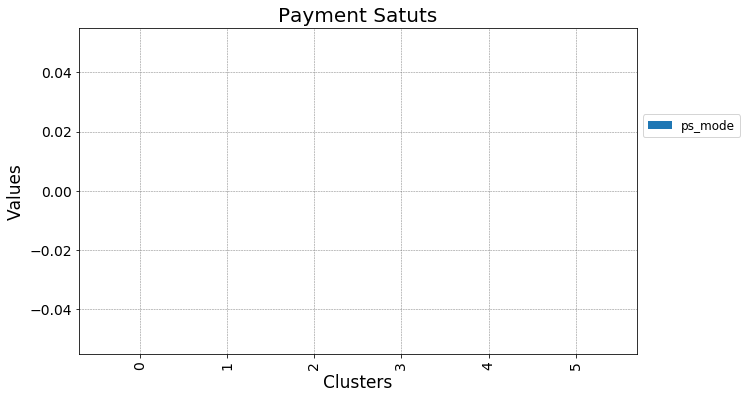

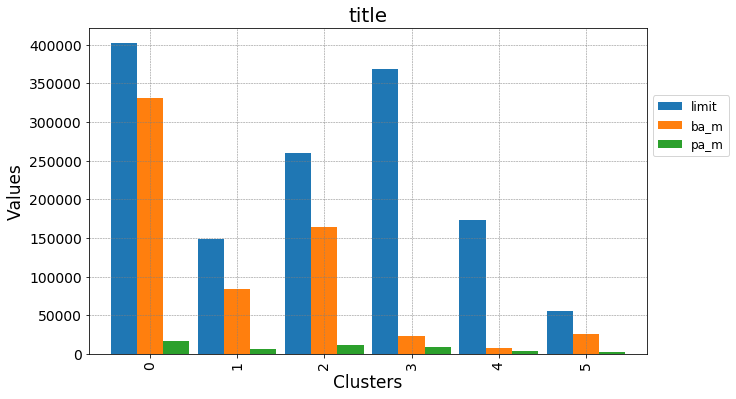

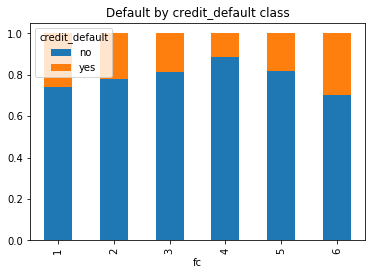

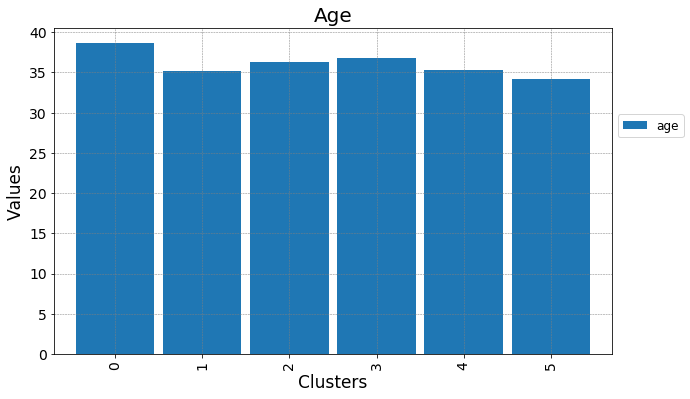

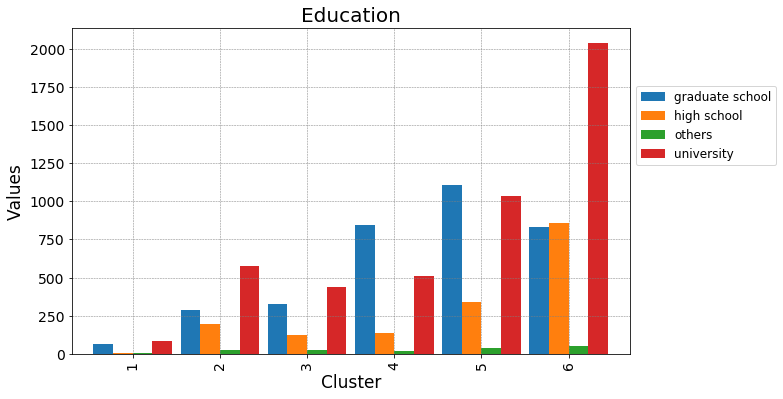

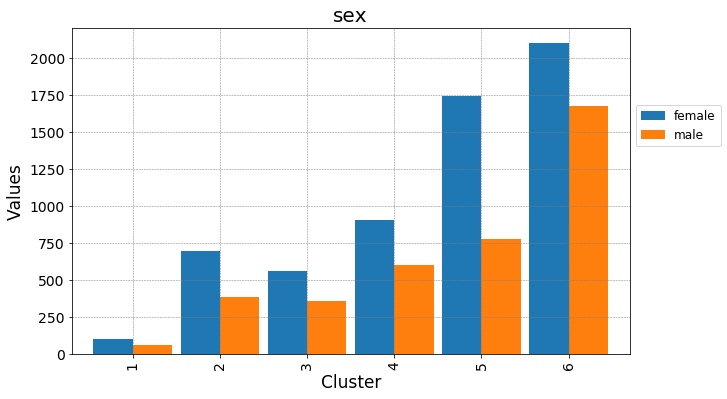

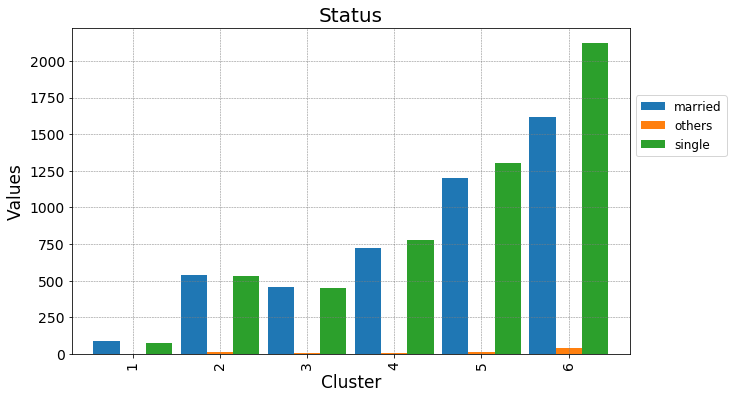

In [59]:
plot_res(cc_2, test_1_30, 'ward', 6, 'mode') # 6 cluster

ward
sh = 0.4283042637747065 - num_cl = 4
  -> {4: 6298, 2: 1997, 3: 1510, 1: 165}


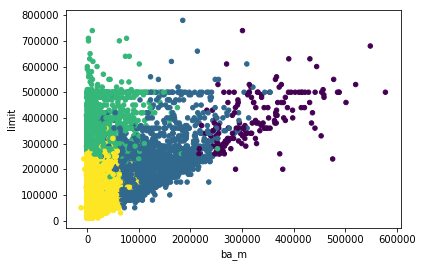

<Figure size 432x288 with 0 Axes>

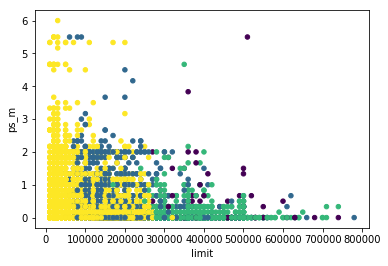

ward
sh = 0.3630705421951882 - num_cl = 5
  -> {5: 6298, 3: 915, 2: 1082, 4: 1510, 1: 165}


<Figure size 432x288 with 0 Axes>

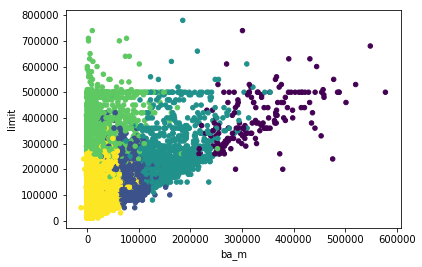

<Figure size 432x288 with 0 Axes>

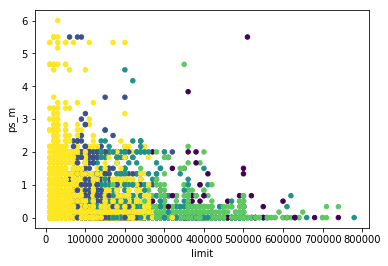

ward
sh = 0.2906636518672859 - num_cl = 6
  -> {6: 3778, 5: 2520, 3: 915, 2: 1082, 4: 1510, 1: 165}


<Figure size 432x288 with 0 Axes>

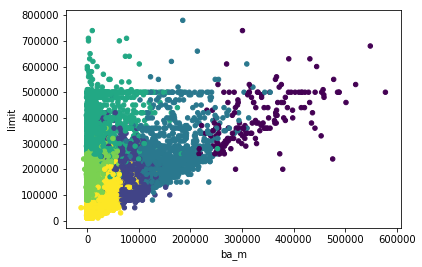

<Figure size 432x288 with 0 Axes>

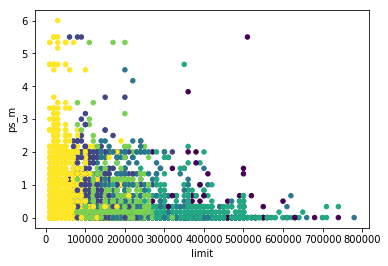

ward
sh = 0.3037673275522348 - num_cl = 7
  -> {7: 3778, 6: 2520, 3: 915, 2: 1082, 4: 1276, 5: 234, 1: 165}


<Figure size 432x288 with 0 Axes>

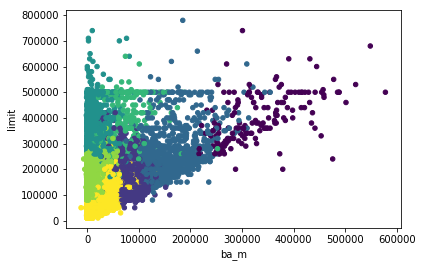

<Figure size 432x288 with 0 Axes>

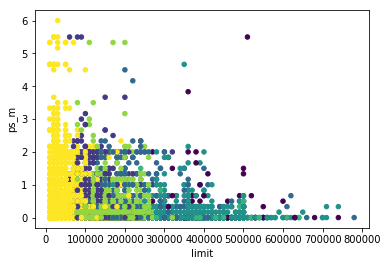

<Figure size 432x288 with 0 Axes>

In [103]:
plot_scatt(cc_2, test_1_30, 'ward', [4,5,6,7], [('ba_m', 'limit'), ('limit', 'ps_m')])

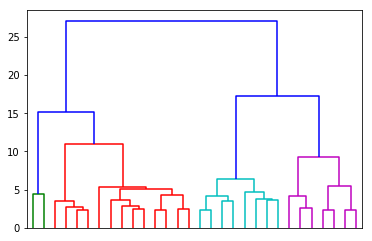

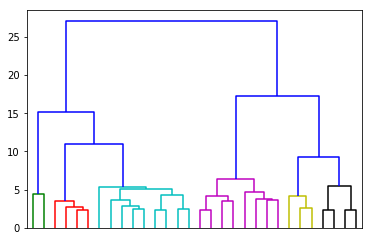

In [48]:
plot_dend(test_1_30, 'ward', [4,6])

# Test 2 - limit, ba_m, pa_m, ps_m

In [63]:
cc = cc_2[['limit', 'ba_m', 'pa_m', 'ps_m']] #test_2

In [68]:
#hier_clu('test_2_30', cc, 31, 'euclidean')  #dictionary of test 2 - 30 cluster

with open('test_2_30.pkl', 'rb') as f:
    test_2_30 = pickle.load(f)

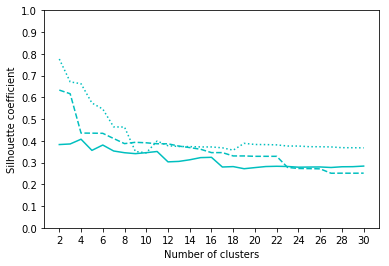

In [69]:
plot_sh(test_2_30)

sh = 0.4073579484234566 - num_cl = 4
  -> {2: 6356, 1: 548, 3: 1584, 4: 1482}


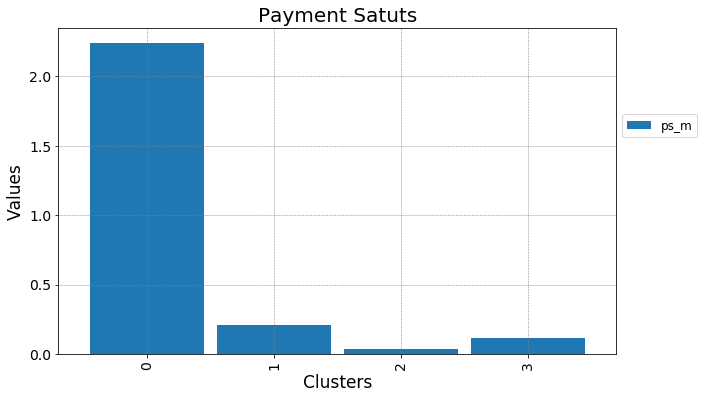

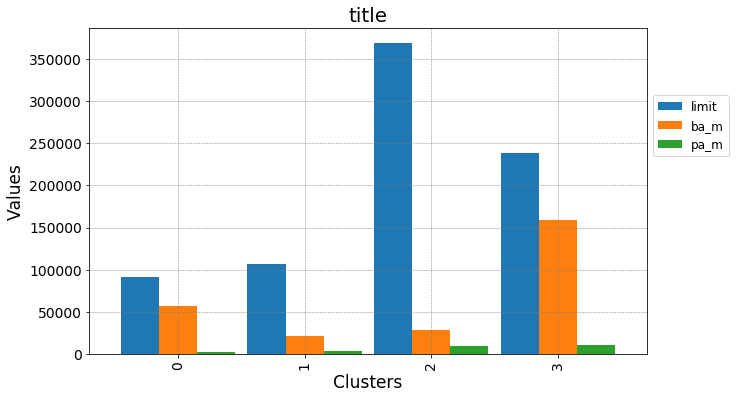

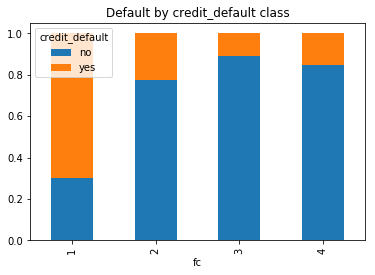

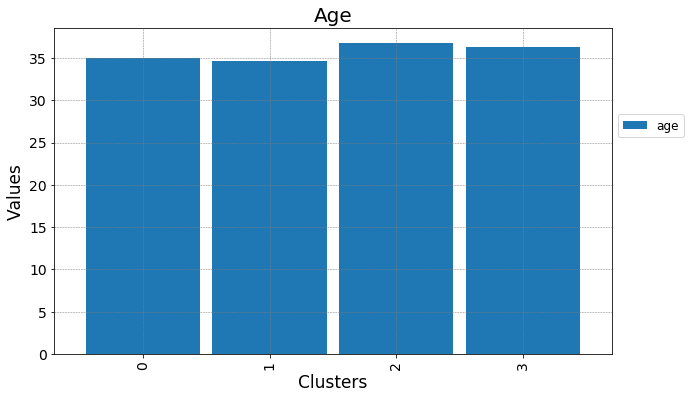

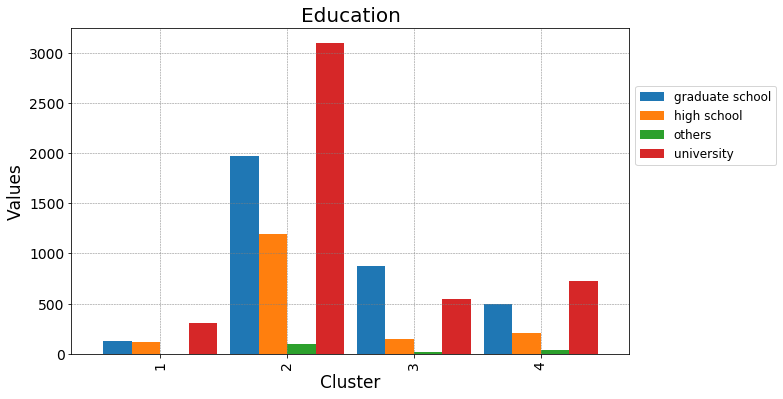

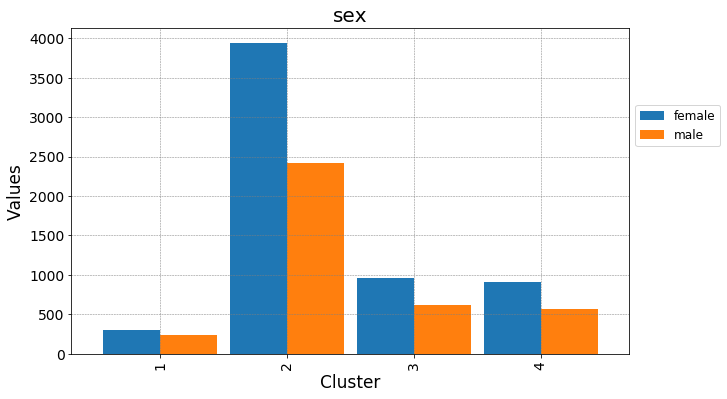

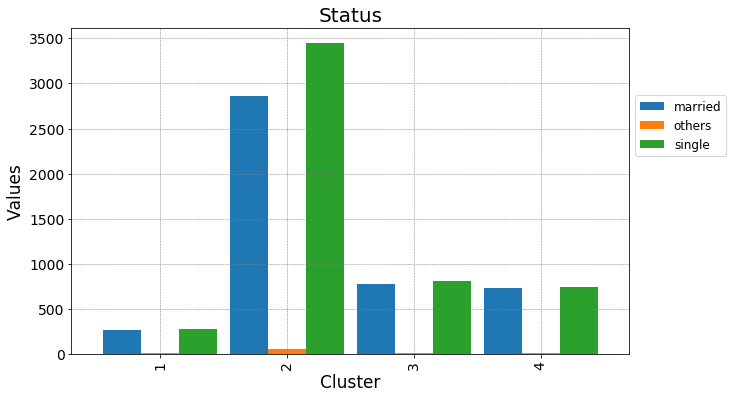

In [104]:
plot_res(cc_2, test_2_30, 'ward', 4, 'mean')

sh = 0.380671545108177 - num_cl = 6
  -> {3: 3946, 2: 2410, 1: 548, 4: 1584, 5: 265, 6: 1217}


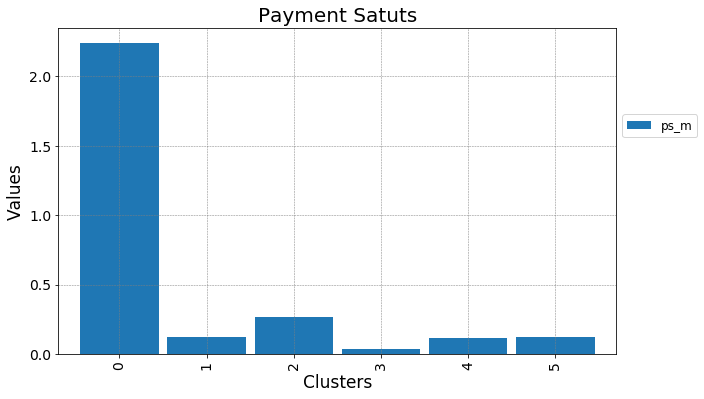

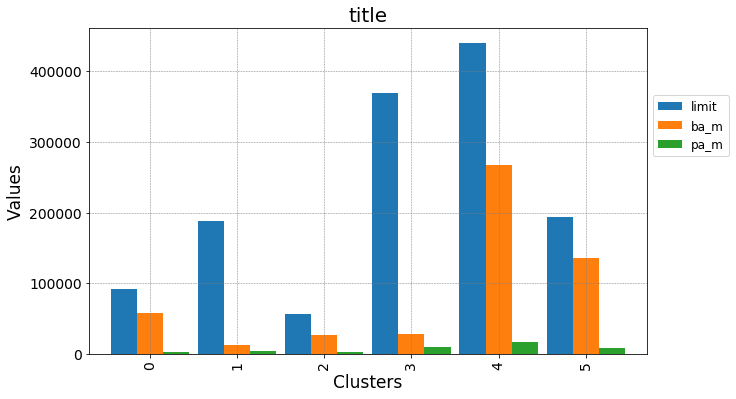

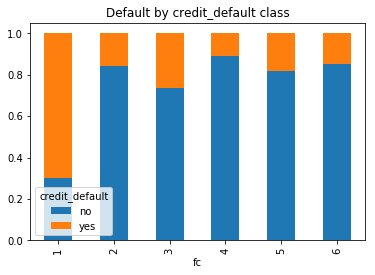

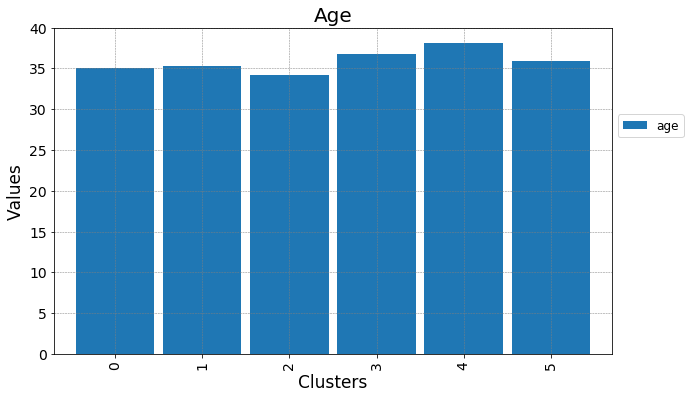

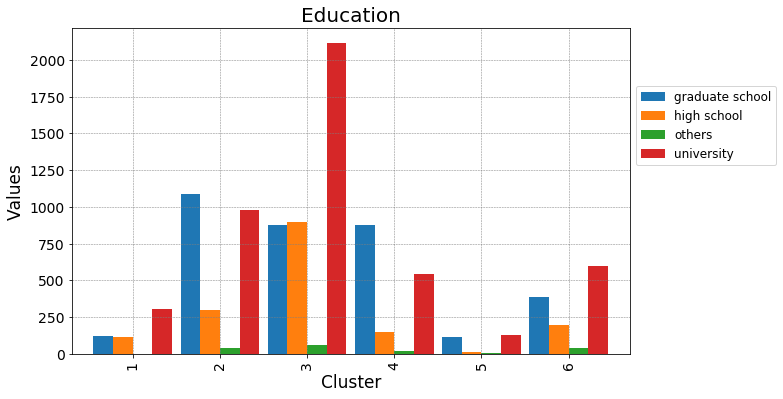

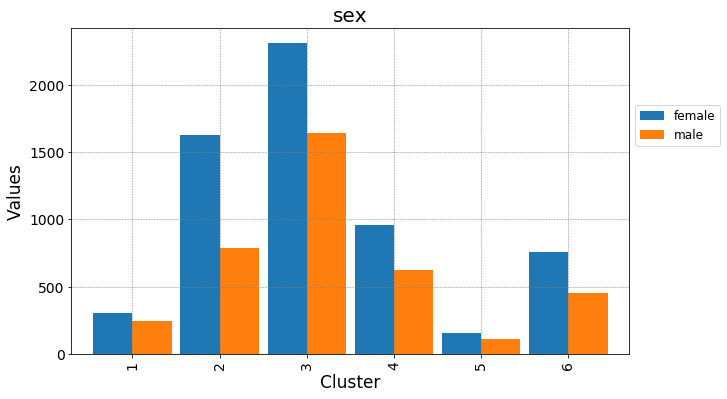

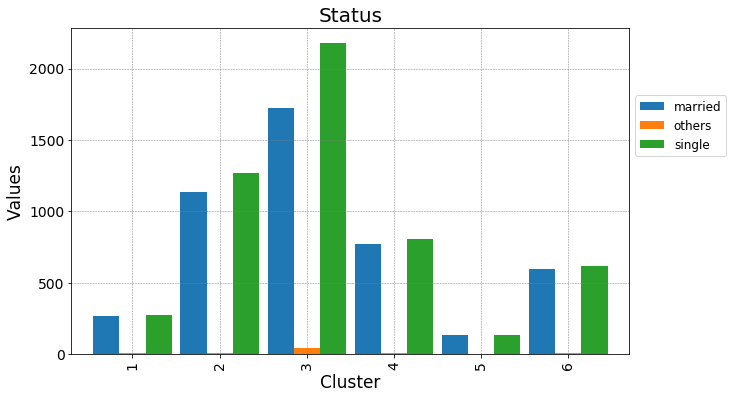

In [100]:
plot_res(cc_2, test_2_30, 'ward', 6, 'mean')

ward
sh = 0.4073579484234566 - num_cl = 4
  -> {2: 6356, 1: 548, 3: 1584, 4: 1482}


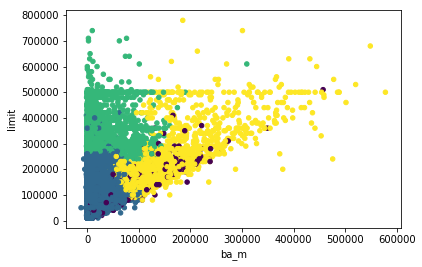

<Figure size 432x288 with 0 Axes>

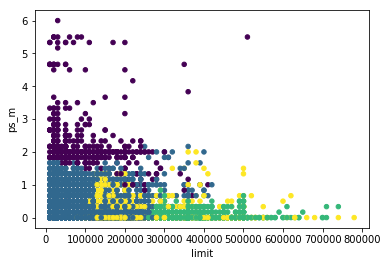

ward
sh = 0.35604214449095495 - num_cl = 5
  -> {3: 3946, 2: 2410, 1: 548, 4: 1584, 5: 1482}


<Figure size 432x288 with 0 Axes>

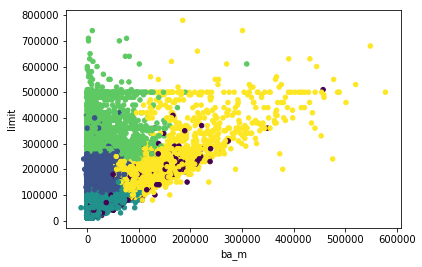

<Figure size 432x288 with 0 Axes>

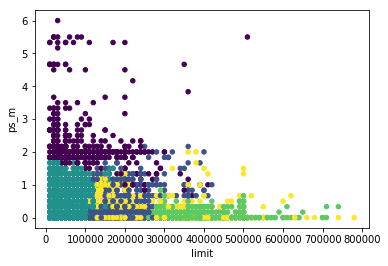

ward
sh = 0.380671545108177 - num_cl = 6
  -> {3: 3946, 2: 2410, 1: 548, 4: 1584, 5: 265, 6: 1217}


<Figure size 432x288 with 0 Axes>

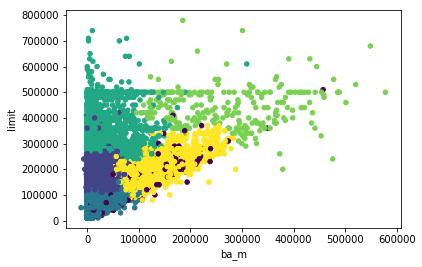

<Figure size 432x288 with 0 Axes>

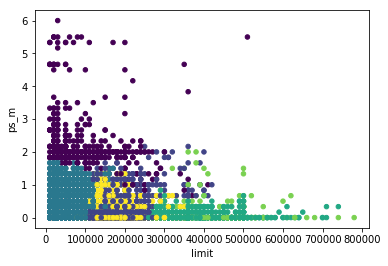

ward
sh = 0.3532004462708633 - num_cl = 7
  -> {3: 3120, 2: 2410, 1: 548, 4: 826, 5: 1584, 6: 265, 7: 1217}


<Figure size 432x288 with 0 Axes>

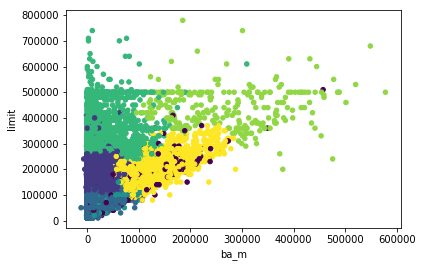

<Figure size 432x288 with 0 Axes>

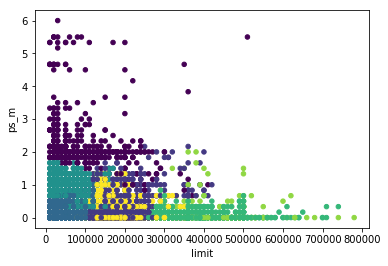

<Figure size 432x288 with 0 Axes>

In [101]:
plot_scatt(cc_2, test_2_30, 'ward', [4,5,6,7], [('ba_m', 'limit'), ('limit', 'ps_m')])

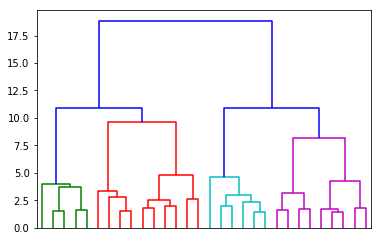

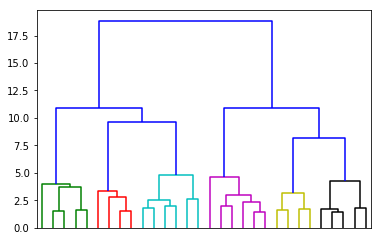

In [47]:
plot_dend(test_2_30, 'ward', [4,6])

# Test 3 - limit, ba_m, pa_m

In [78]:
cc = cc_2[['limit', 'ba_m', 'pa_m']] #test_3

In [ ]:
#hier_clu('test_3_30', cc, 31, 'euclidean')  #dictionary of test 2 - 30 cluster

with open('test_3_30.pkl', 'rb') as f:
    test_3_30 = pickle.load(f)

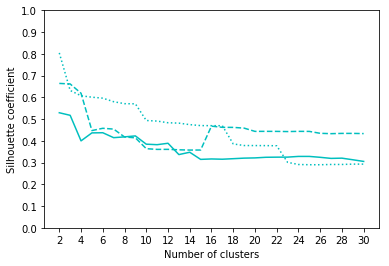

In [80]:
plot_sh(test_3_30)

sh = 0.39982374655878633 - num_cl = 4
  -> {1: 3559, 2: 4052, 4: 1797, 3: 562}


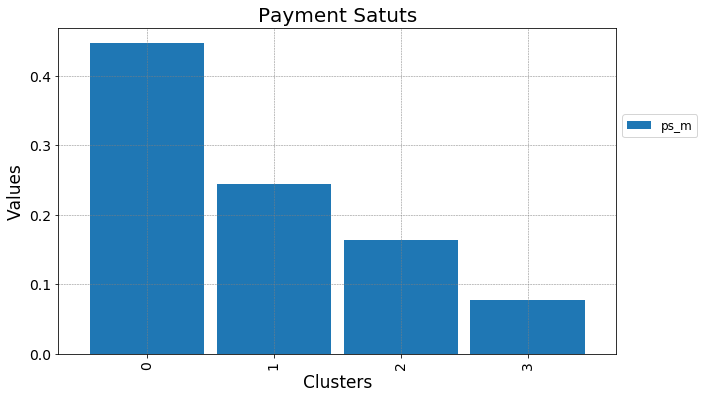

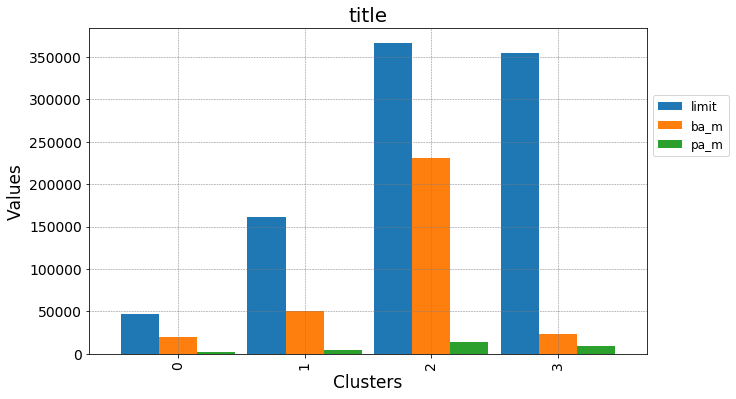

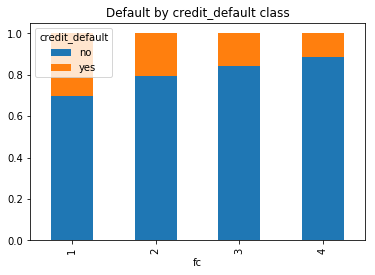

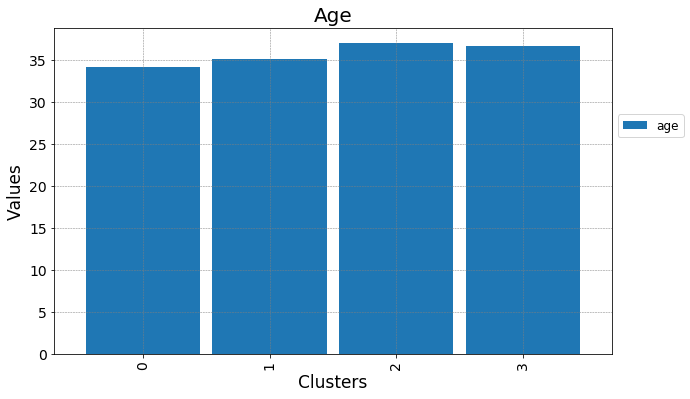

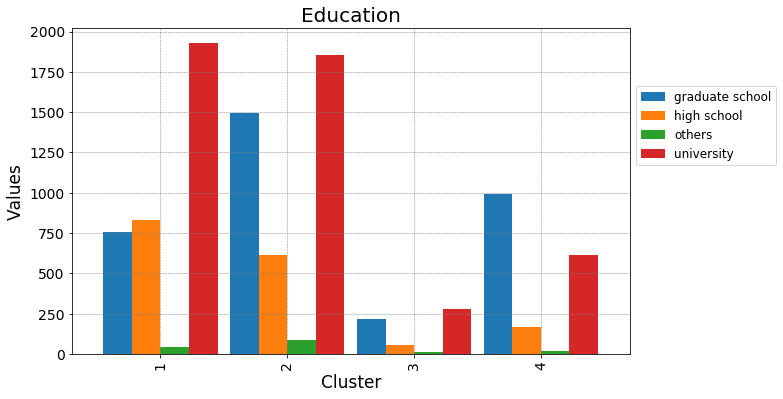

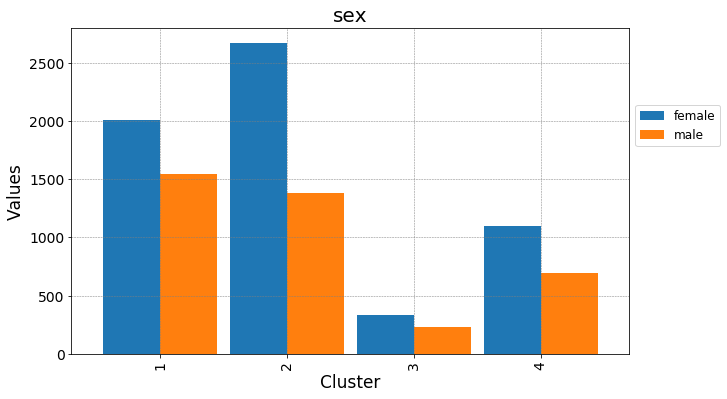

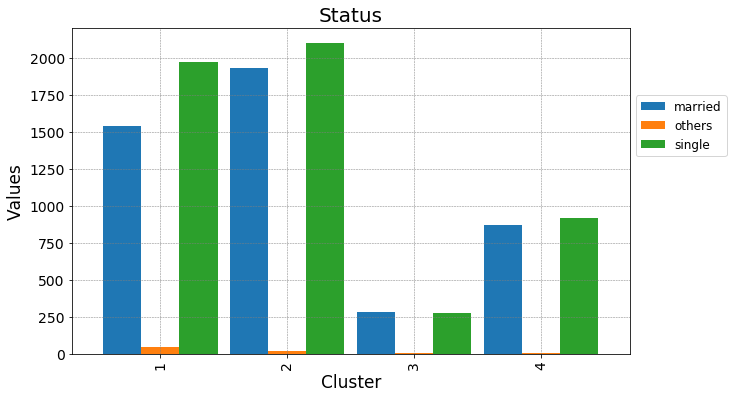

In [87]:
plot_res(cc_2, test_3_30, 'ward', 4, 'mean')

sh = 0.4372090029074527 - num_cl = 6
  -> {1: 3559, 2: 2390, 6: 1461, 3: 1662, 5: 336, 4: 562}


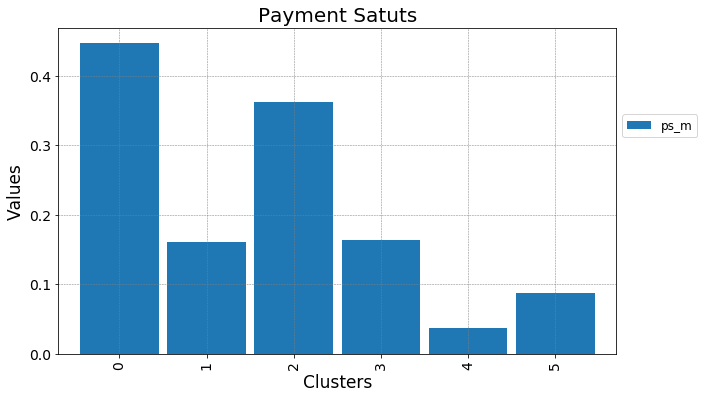

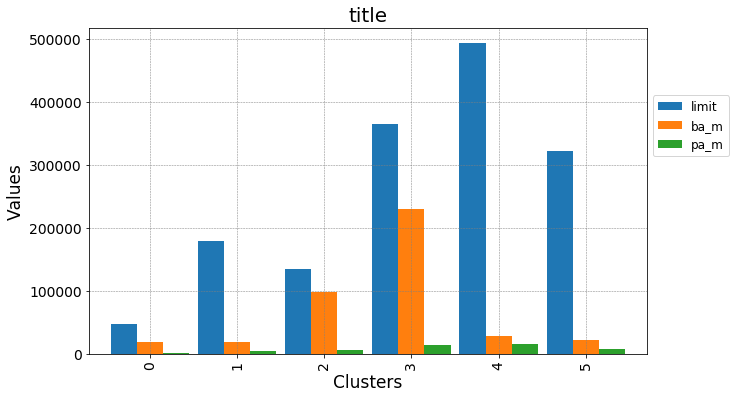

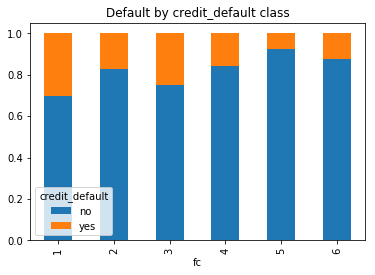

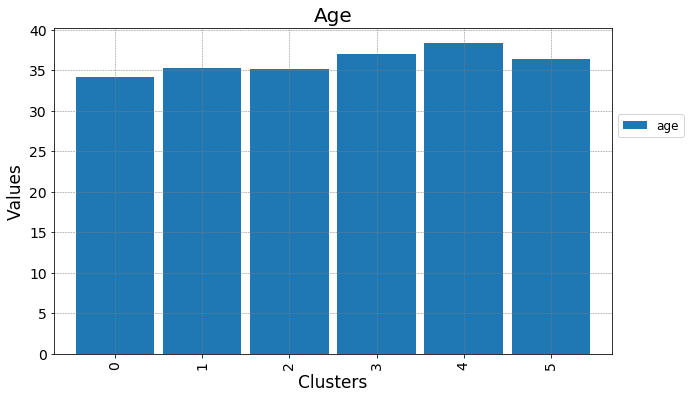

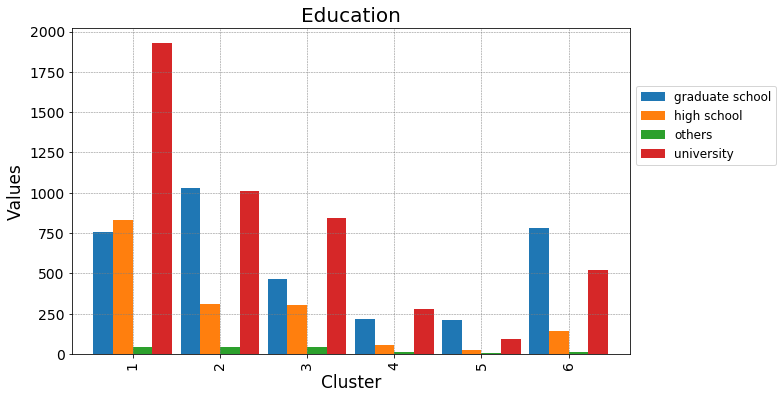

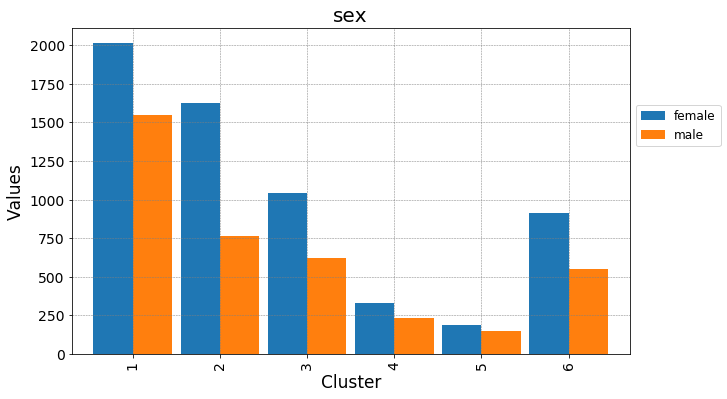

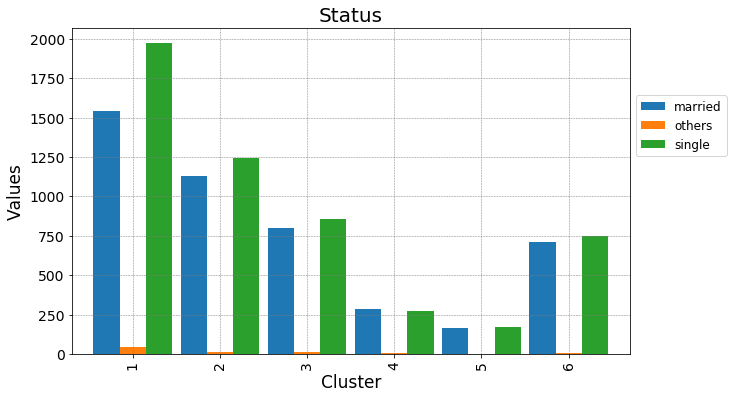

In [81]:
plot_res(cc_2, test_3_30, 'ward', 6, 'mean')

ward
sh = 0.39982374655878633 - num_cl = 4
  -> {1: 3559, 2: 4052, 4: 1797, 3: 562}


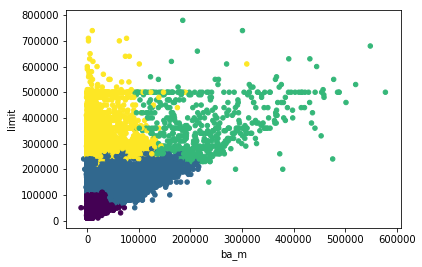

<Figure size 432x288 with 0 Axes>

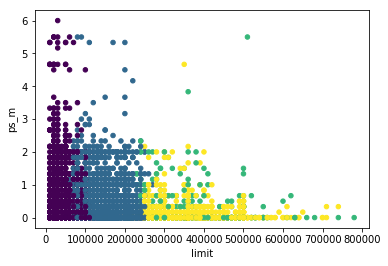

ward
sh = 0.43649004839355765 - num_cl = 5
  -> {1: 3559, 2: 2390, 5: 1797, 3: 1662, 4: 562}


<Figure size 432x288 with 0 Axes>

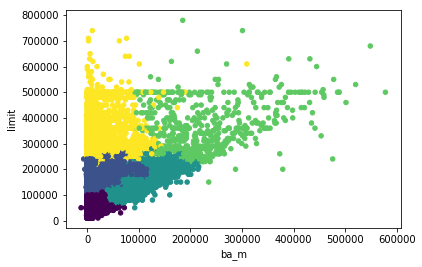

<Figure size 432x288 with 0 Axes>

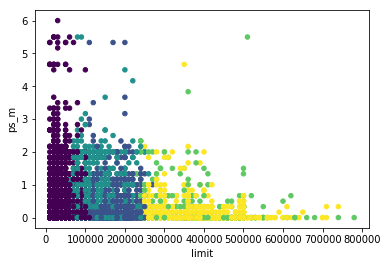

ward
sh = 0.4372090029074527 - num_cl = 6
  -> {1: 3559, 2: 2390, 6: 1461, 3: 1662, 5: 336, 4: 562}


<Figure size 432x288 with 0 Axes>

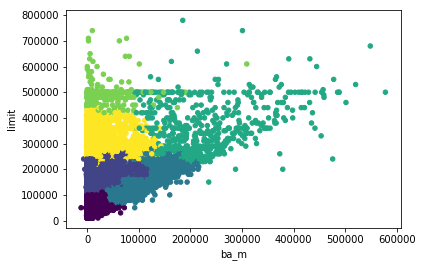

<Figure size 432x288 with 0 Axes>

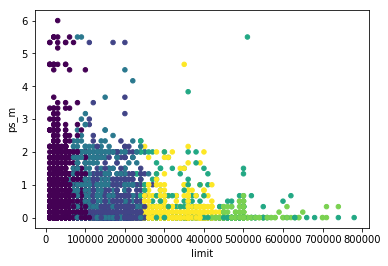

ward
sh = 0.41454536451445106 - num_cl = 7
  -> {1: 3559, 2: 2390, 7: 1461, 3: 425, 4: 1237, 6: 336, 5: 562}


<Figure size 432x288 with 0 Axes>

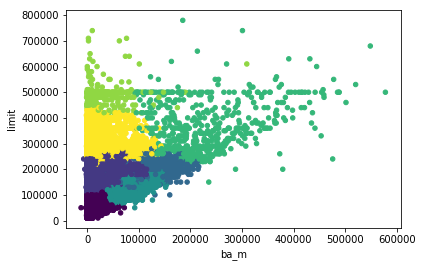

<Figure size 432x288 with 0 Axes>

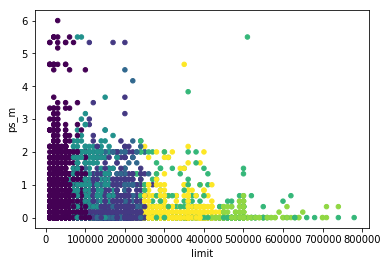

<Figure size 432x288 with 0 Axes>

In [99]:
plot_scatt(cc_2, test_3_30, 'ward', [4,5,6,7], [('ba_m', 'limit'), ('limit', 'ps_m')])

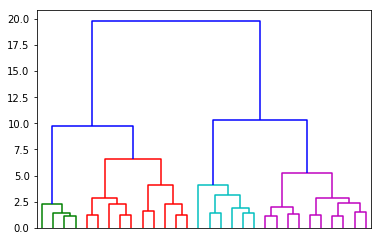

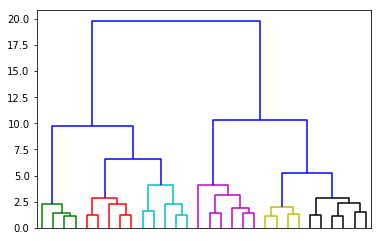

In [46]:
plot_dend(test_3_30, 'ward', [4,6])

# Test 4 - ba_m, pa_m, ps_m

In [49]:
cc = cc_2[['ba_m', 'pa_m', 'ps_m']] #test_2

In [ ]:
#hier_clu('test_4_30', cc, 31, 'euclidean')  #dictionary of test 4 - 30 cluster

with open('test_4_30.pkl', 'rb') as f:
    test_4_30 = pickle.load(f)

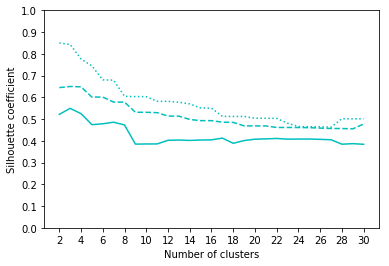

In [51]:
plot_sh(test_4_30)

sh = 0.5249313189109115 - num_cl = 4
  -> {1: 7483, 2: 641, 4: 1645, 3: 201}


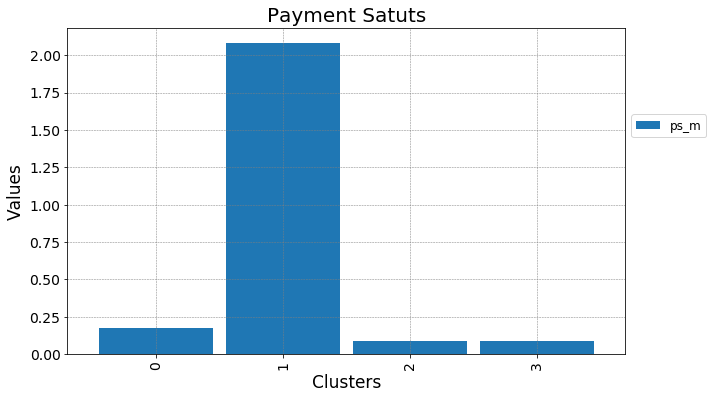

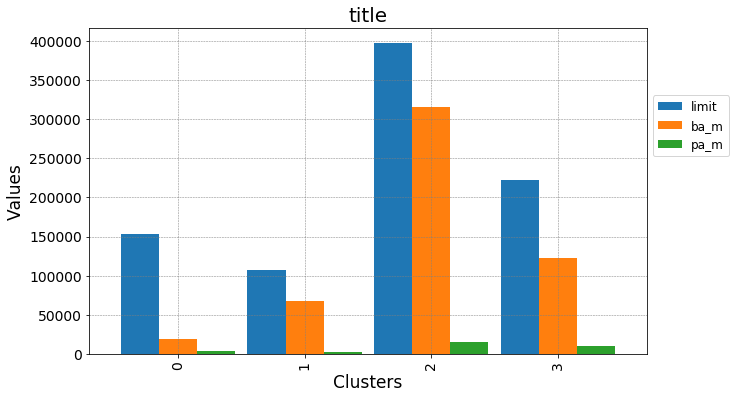

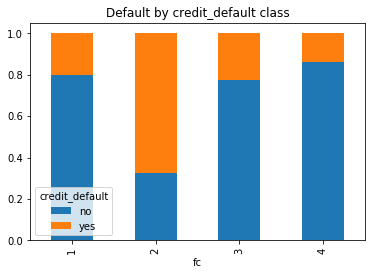

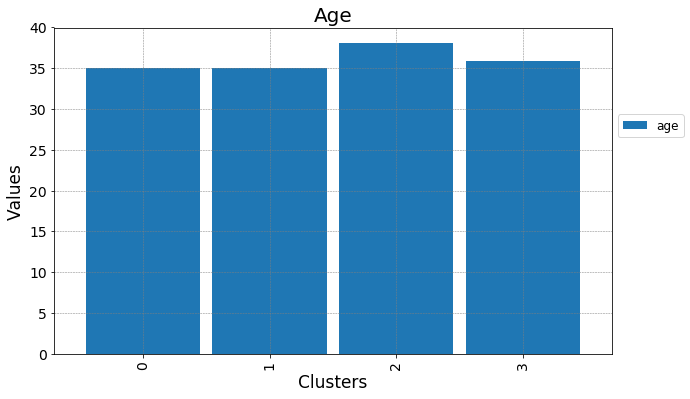

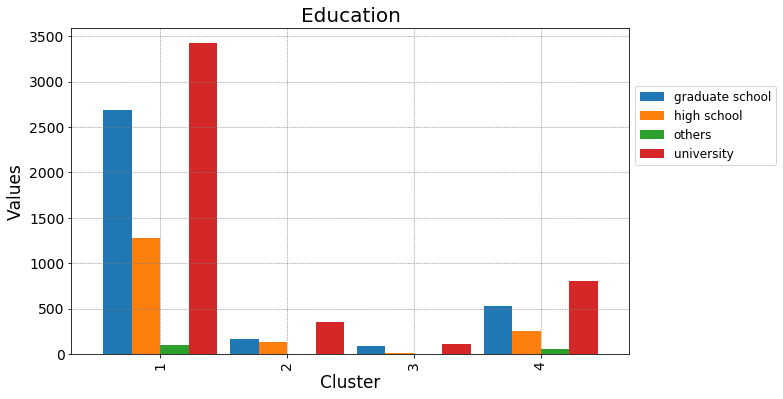

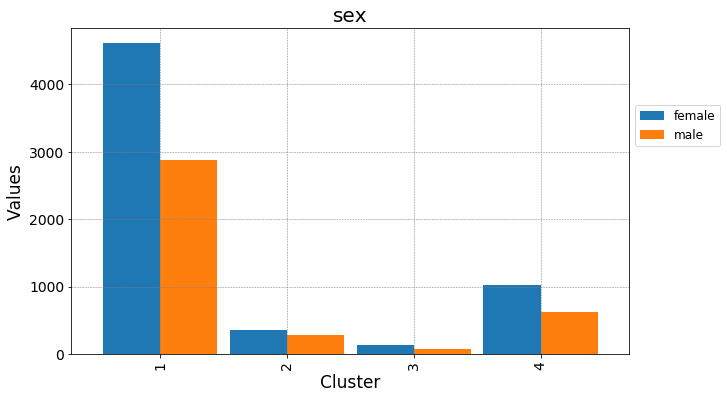

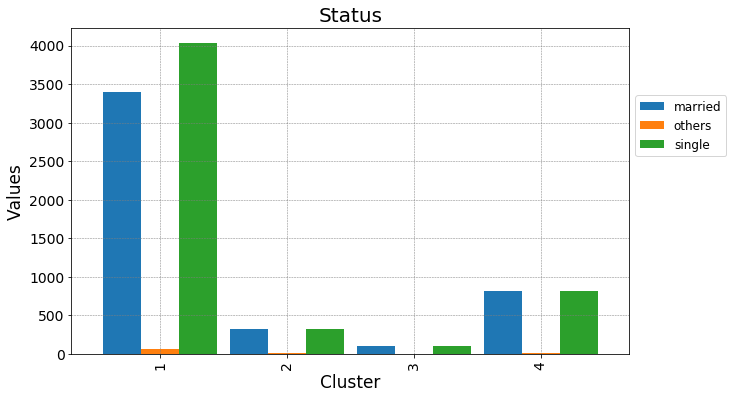

In [52]:
plot_res(cc_2, test_4_30, 'ward', 4, 'mean')

sh = 0.47839340933038754 - num_cl = 6
  -> {1: 1415, 2: 6068, 4: 609, 6: 1645, 3: 32, 5: 201}


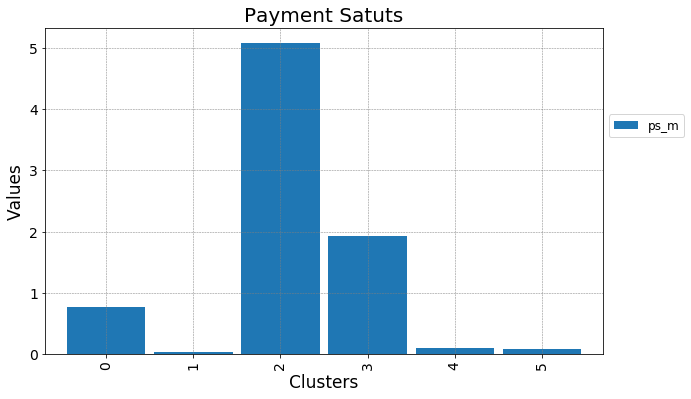

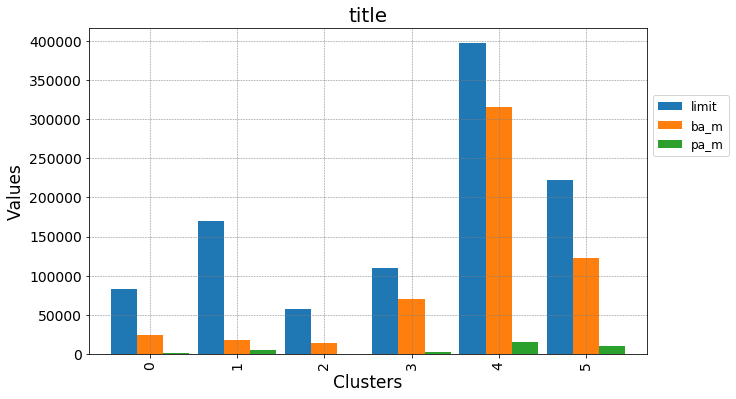

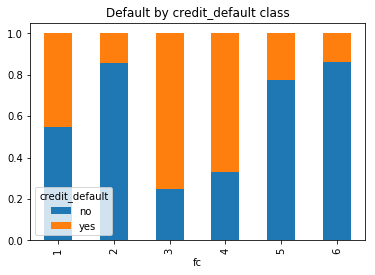

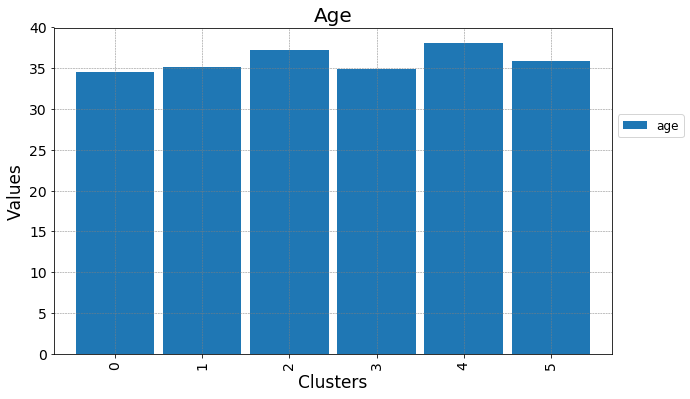

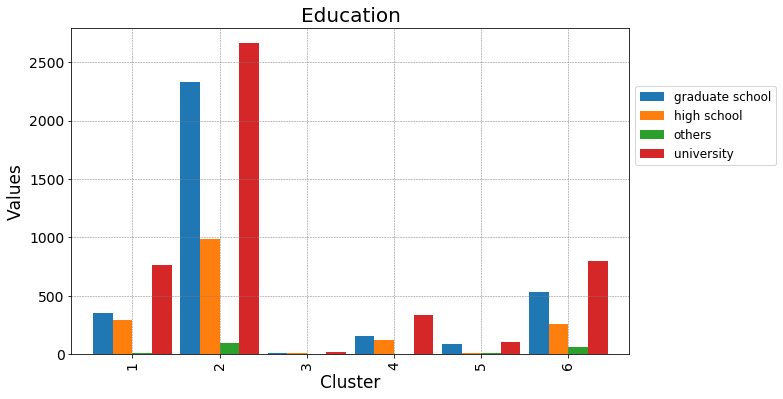

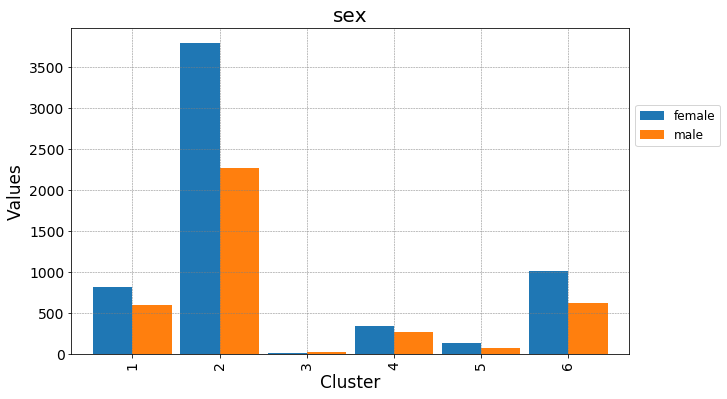

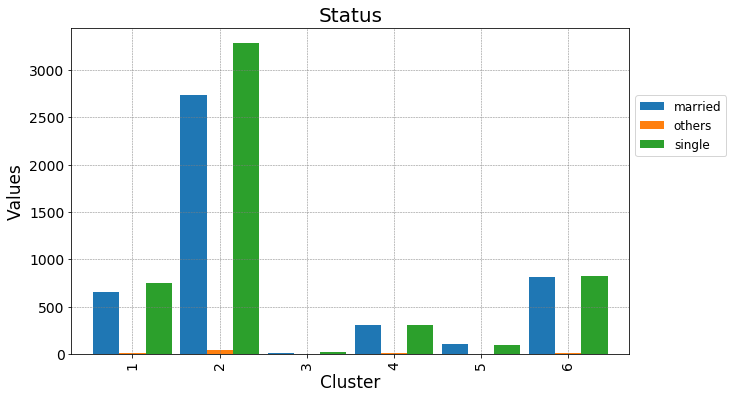

In [53]:
plot_res(cc_2, test_4_30, 'ward', 6, 'mean')

ward
sh = 0.5249313189109115 - num_cl = 4
  -> {1: 7483, 2: 641, 4: 1645, 3: 201}


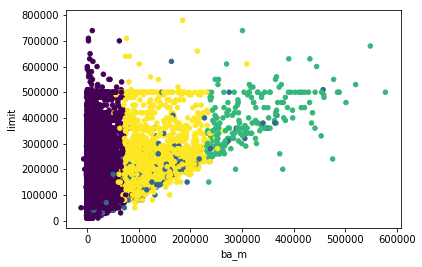

<Figure size 432x288 with 0 Axes>

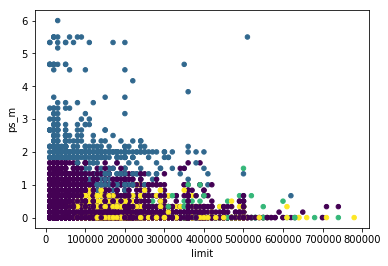

ward
sh = 0.47839340933038754 - num_cl = 6
  -> {1: 1415, 2: 6068, 4: 609, 6: 1645, 3: 32, 5: 201}


<Figure size 432x288 with 0 Axes>

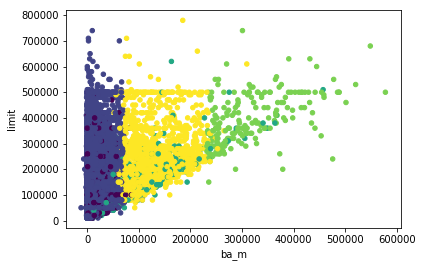

<Figure size 432x288 with 0 Axes>

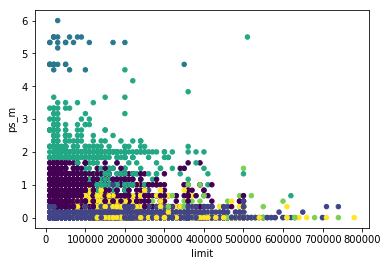

<Figure size 432x288 with 0 Axes>

In [54]:
plot_scatt(cc_2, test_4_30, 'ward', [4,6], [('ba_m', 'limit'), ('limit', 'ps_m')])

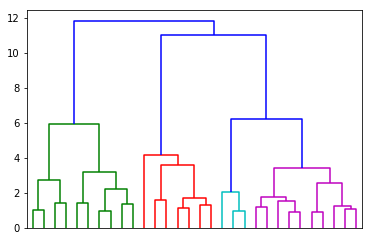

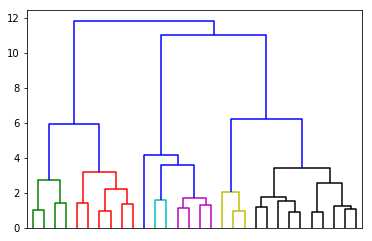

In [55]:
plot_dend(test_4_30, 'ward', [4,6])

# Shilouette coefficient comparison

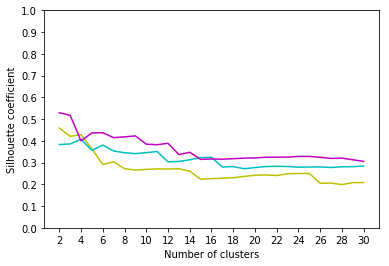

In [95]:
d1 = {l: [test_1_30[l]['sh'][k] for k in test_1_30[l]['sh']] for l in linkage_list}
d2 = {l: [test_2_30[l]['sh'][k] for k in test_2_30[l]['sh']] for l in linkage_list}
d3 = {l: [test_3_30[l]['sh'][k] for k in test_3_30[l]['sh']] for l in linkage_list}

df_1 = pd.DataFrame(data=d1)
df_2 = pd.DataFrame(data=d2)
df_3 = pd.DataFrame(data=d3)

fig = plt.figure()

plt.plot(df_1['ward'], 'y')
#plt.plot(df_1['complete'], '--y')
#plt.plot(df_1['average'], ':y')

plt.plot(df_2['ward'], 'c')
#plt.plot(df_2['complete'], '--c')
#plt.plot(df_2['average'], ':c')
    
plt.plot(df_3['ward'], 'm')
#plt.plot(df_3['complete'], '--m')
#plt.plot(df_3['average'], ':m')


plt.ylim(top=1)
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 30, step=2), [x for x in range(2,31,2)])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette coefficient')

plt.show()
#plt.savefig('hier_num_clust_sh.png')
#plt.clf()